## **Part A)**

<p dir = "rtl">
در زمینه یادگیری عمیق، VQ-VAE با VAE  تفاوت‌های معناداری دارد. یکی از نقاط برتر VQ-VAE، استفاده از لایه کد کوانتایزر است که با محدود کردن کد‌های نهفته به فضای کوانتایز شده، ساختارهای دقیقتری ایجاد می‌کند. این شبکه تنها از یک نمونه از توزیع مخفی برای هر واحد در فضای کوانتایز استفاده کرده و از کد‌های گسسته بهره‌مند است که می‌تواند در مسائلی که نیاز به بازنمایی دقیق داریم، مزیت داشته باشد. علاوه بر این، امکان تعلیم دیتا-درایون برای کدبوک در VQ-VAE، به مدل این امکان را می‌دهد که بهترین نمایش‌ها را به صورت اتوماتیک یاد بگیرد. همچنین، VQ-VAE از تابع خطای VQ loss برای آموزش کدبوک استفاده می‌کند که باعث می‌شود که کد‌ها به نمایش‌های معنی‌دار و قابل تفسیر تبدیل شوند. این تفاوت‌ها نشان‌دهنده‌ی پتانسیل VQ-VAE در بهبود بازنمایی داده‌ها و استفاده از اطلاعات گسسته در مسائل مختلف می‌باشند.
</p>

## **Part B)**

In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

In [79]:
batch_size = 64
num_epochs = 50
learning_rate = 1e-3
embedding_dim = 256
num_embeddings = 200
commitment_cost = 0.5

In [80]:
transform = transforms.Compose([transforms.ToTensor()])
train_loader = DataLoader(datasets.MNIST('./data', train=True, download=True, transform=transform),
                          batch_size=batch_size, shuffle=True, pin_memory=True)

## **Part C)**

In [81]:
class VectorQuantizer(nn.Module):
    def __init__(self, embedding_dim, num_embeddings, commitment_cost):
        super(VectorQuantizer, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost

        self.codebook = nn.Embedding(num_embeddings, embedding_dim)
        self.codebook.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)

    def forward(self, x):
        x_flat = x.view(-1, self.embedding_dim)

        distances = torch.sum(x_flat**2, dim=1, keepdim=True) + \
                    torch.sum(self.codebook.weight**2, dim=1) - \
                    2 * torch.matmul(x_flat, self.codebook.weight.t())

        indices = torch.argmin(distances, dim=1)

        quantized = self.codebook(indices).view(x.size())
        e_latent_loss = torch.mean((x.detach() - quantized)**2)

        commitment_loss = self.commitment_cost * e_latent_loss

        recon_loss = nn.MSELoss()(quantized, x)

        return quantized, indices, e_latent_loss, commitment_loss, recon_loss

class VQVAE(nn.Module):
    def __init__(self, input_channels, embedding_dim, num_embeddings, commitment_cost):
        super(VQVAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.vq_layer = VectorQuantizer(embedding_dim, num_embeddings, commitment_cost)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embedding_dim, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_channels, kernel_size=3, stride=3, padding=4)
        )

    def forward(self, x):
        z = self.encoder(x)
        quantized, indices, e_latent_loss, commitment_loss, recon_loss = self.vq_layer(z)
        x_recon = self.decoder(quantized)
        return x_recon, indices, e_latent_loss, commitment_loss, recon_loss


## **Part D)**

In [82]:
model = VQVAE(input_channels=1, embedding_dim=embedding_dim, num_embeddings=num_embeddings, commitment_cost=commitment_cost)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## **Part E)**

In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    for data, _ in train_loader:
        data = data.to(device)

        optimizer.zero_grad()
        recon, _, e_latent_loss, commitment_loss, recon_loss = model(data)

        reloss = criterion(recon, data)
        loss = reloss + e_latent_loss + commitment_loss

        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/50], Loss: 0.5848
Epoch [2/50], Loss: 0.5803
Epoch [3/50], Loss: 0.5779
Epoch [4/50], Loss: 0.5776
Epoch [5/50], Loss: 0.5842
Epoch [6/50], Loss: 0.5834
Epoch [7/50], Loss: 0.5800
Epoch [8/50], Loss: 0.5709
Epoch [9/50], Loss: 0.5515
Epoch [10/50], Loss: 0.5334
Epoch [11/50], Loss: 0.4896
Epoch [12/50], Loss: 0.4839
Epoch [13/50], Loss: 0.4722
Epoch [14/50], Loss: 0.4772
Epoch [15/50], Loss: 0.4772
Epoch [16/50], Loss: 0.4772
Epoch [17/50], Loss: 0.4655
Epoch [18/50], Loss: 0.4444
Epoch [19/50], Loss: 0.4598
Epoch [20/50], Loss: 0.4561
Epoch [21/50], Loss: 0.4325
Epoch [22/50], Loss: 0.4532
Epoch [23/50], Loss: 0.4548
Epoch [24/50], Loss: 0.4473
Epoch [25/50], Loss: 0.4437
Epoch [26/50], Loss: 0.4256
Epoch [27/50], Loss: 0.4441
Epoch [28/50], Loss: 0.4312
Epoch [29/50], Loss: 0.4246
Epoch [30/50], Loss: 0.4308
Epoch [31/50], Loss: 0.4179
Epoch [32/50], Loss: 0.4338
Epoch [33/50], Loss: 0.4361
Epoch [34/50], Loss: 0.4270
Epoch [35/50], Loss: 0.4162
Epoch [36/50], Loss: 0.4170
E

## **Part F)**

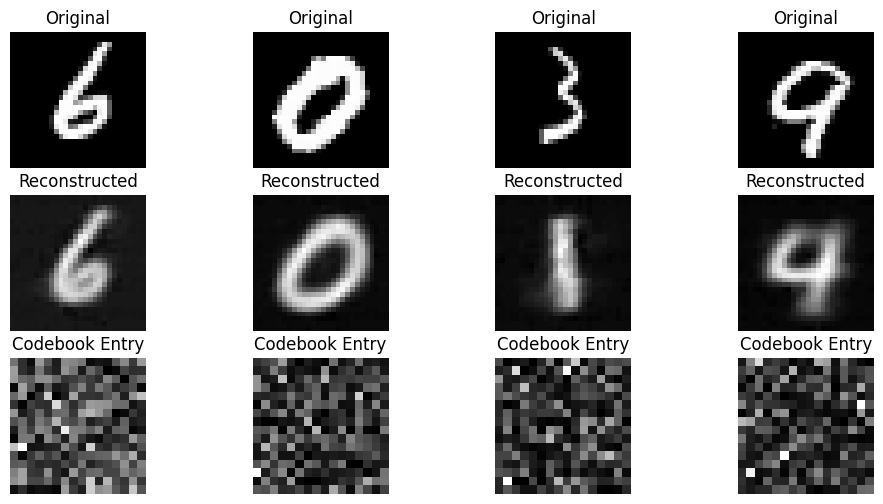

In [76]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
    test_batch, _ = next(iter(DataLoader(datasets.MNIST('./data', train=False, download=True, transform=transform),
                                         batch_size=batch_size, shuffle=True, pin_memory=True)))

    test_batch = test_batch.to(device)
    recon_batch, indices, _, _, _ = model(test_batch)
    codebook_entries = model.vq_layer.codebook(indices)

def plot_images(original, reconstructed, codebook_entries):
    plt.figure(figsize=(12, 6))

    for i in range(4):
        plt.subplot(3, 4, i + 1)
        plt.imshow(original[i].cpu().squeeze(), cmap='gray')
        plt.title("Original")
        plt.axis("off")

        plt.subplot(3, 4, i + 5)
        plt.imshow(reconstructed[i].cpu().squeeze(), cmap='gray')
        plt.title("Reconstructed")
        plt.axis("off")

        plt.subplot(3, 4, i + 9)
        plt.imshow(codebook_entries[i].cpu().squeeze().reshape(16,16), cmap='gray')
        plt.title("Codebook Entry")
        plt.axis("off")

    plt.show()

plot_images(test_batch, recon_batch, codebook_entries)


## **Part G)**

In [152]:
import numpy as np

def random_multiply(image):
    random_factors = np.random.rand(3)
    return torch.round(transforms.ToTensor()(np.concatenate([image*random_factors[0],image*random_factors[1],image*random_factors[2]])))

In [153]:
transform_color = transforms.Compose([
    transforms.Lambda(lambda x: random_multiply(x)),

])

original_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform_color)

In [154]:
from torch.utils.data import DataLoader, random_split

train_size = int(0.8 * len(original_dataset))
val_size = len(original_dataset) - train_size
train_dataset, val_dataset = random_split(original_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

In [ ]:
model = VQVAE(input_channels=3, embedding_dim=embedding_dim, num_embeddings=num_embeddings, commitment_cost=commitment_cost)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for data, _ in train_loader:
        data = data.to(device)

        optimizer.zero_grad()
        recon, _, e_latent_loss, commitment_loss, recon_loss = model(data)

        loss = recon_loss + e_latent_loss + commitment_loss

        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, _ in val_loader:
            data = data.to(device)
            recon, _, e_latent_loss, commitment_loss, recon_loss = model(data)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}")

torch.save(model.state_dict(), 'vqvae_model.pth')